In [55]:
from matplotlib import colormaps
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple, Dict
import pandas as pd
import os
import re
import json
import subprocess
import numpy as np
from scipy import stats
from collections import defaultdict, namedtuple
import math as ma
import seaborn as sns
import importlib

import grouping
importlib.reload(grouping)
from grouping import get_groups, ValuesGroup, print_groups, extract_group

#### Global variables

In [3]:
TRACE_CMD_CACHE_FILENAME = "trace_cmd_runtimes"
RESULTS_DIR_PATH = "../results"
ABSOLUTE_RESULTS_DIR_PATH = "/home/cgachod/analysis/results"

WORKING_DIR = "/root/tests"
PERF_SCRIPT_RESULTS_FILEPATH = f"{WORKING_DIR}/.perf_mem_results.log"

NODE_1_PHYS_ADDR_START = 0x1840000000

DAHU_NODE_0_CPUID = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62]
DAHU_NODE_1_CPUID = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63]
dahu_cpu_nodes = [1 if cpuid in DAHU_NODE_1_CPUID else 0 for cpuid in range(64)]

def in_working_dir(path: str) :
    return os.path.join(WORKING_DIR, path)

In [4]:
CPUID_TO_NODE = {}
matches = re.findall(
    r"NUMA +node\d+ +CPU\(s\): +([\d,]+)", 
    subprocess.run("lscpu", stdout = subprocess.PIPE, universal_newlines = True).stdout
)

node_id = 0
for cpulist in matches:
    for cpuid in cpulist.split(','):
        CPUID_TO_NODE[int(cpuid)] = node_id
    node_id += 1

print(CPUID_TO_NODE)

{0: 0, 2: 0, 4: 0, 6: 0, 8: 0, 10: 0, 12: 0, 14: 0, 16: 0, 18: 0, 20: 0, 22: 0, 24: 0, 26: 0, 28: 0, 30: 0, 32: 0, 34: 0, 36: 0, 38: 0, 40: 0, 42: 0, 44: 0, 46: 0, 48: 0, 50: 0, 52: 0, 54: 0, 56: 0, 58: 0, 60: 0, 62: 0, 1: 1, 3: 1, 5: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1, 17: 1, 19: 1, 21: 1, 23: 1, 25: 1, 27: 1, 29: 1, 31: 1, 33: 1, 35: 1, 37: 1, 39: 1, 41: 1, 43: 1, 45: 1, 47: 1, 49: 1, 51: 1, 53: 1, 55: 1, 57: 1, 59: 1, 61: 1, 63: 1}


In [5]:
PAGE_SIZE = int(subprocess.run(["getconf", "PAGESIZE"], stdout = subprocess.PIPE, universal_newlines = True).stdout)
print(f"Page size : {PAGE_SIZE}")

matches = re.findall(
    r"start_pfn: +(\d+)\sNode (\d+), +zone +(\w+)", 
    subprocess.run(["cat", "/proc/zoneinfo"], stdout = subprocess.PIPE, universal_newlines = True).stdout
)

# page_size = 4096

node_upper_boundaries = []
for m in matches:
    if int(m[1]) > len(node_upper_boundaries):
        node_upper_boundaries.append(int(m[0]) * PAGE_SIZE)
        
print(f"Node upper boundaries : {node_upper_boundaries}")


def get_node_for_physical_address(addr: int):
    boundary_idx = 0
    while boundary_idx < len(node_upper_boundaries) and addr >= node_upper_boundaries[boundary_idx]:
        boundary_idx += 1
    return boundary_idx


Page size : 4096
Node upper boundaries : [104152956928]


In [6]:
# TODO Make them adapt to the file
LOAD_L3_MISS_REMOTE_FWD = "mem_load_l3_miss_retired.remote_fwd:P"
LOAD_L3_MISS_REMOTE_HITM = "mem_load_l3_miss_retired.remote_hitm:P"
LOAD_L3_MISS_REMOTE_DRAM = "mem_load_l3_miss_retired.remote_dram:P"

LOAD_L3_MISS_REMOTE_FWD_COLOR = "tab:orange"
LOAD_L3_MISS_REMOTE_HITM_COLOR = "tab:pink"
LOAD_L3_MISS_REMOTE_DRAM_COLOR = "r"

In [7]:
class PerfResultsReader:
    def __init__(self, log_file_path = in_working_dir(".perf.log")) -> None:
        self.log_file_path = log_file_path
        self.filtered_log_file_path = "/tmp/perf_results/.perf_filtered.log"
        filtered_dir = os.path.dirname(self.filtered_log_file_path)
        if not os.path.exists(filtered_dir):
            os.makedirs(filtered_dir)
        
    def __get_initial_timestamp(self, data_file_path: str) :
        res = subprocess.run(
            f"perf script -i {data_file_path} -F time | head -1",
            shell=True,
            stdout = subprocess.PIPE,
            universal_newlines = True
        )
        return float(res.stdout.strip(':\n '))
        
    # For example time_option="10%-20%"
    def __extract_perf_data_file_with_latency(self, data_file_path: str, executable: Optional[str], time_option: Optional[str]) -> float:
        initial_timestamp = self.__get_initial_timestamp(data_file_path)
        print(f"Retrieved initial timestamp : {initial_timestamp}")
        
        executable_filter = f"-c {executable}" if executable is not None else ""
        time_filter = f"--time {time_option}" if time_option is not None else ""
        command_str = f"perf script -i {data_file_path} -L {executable_filter} {time_filter} > {self.log_file_path}"
        print(f"Executing extraction command : {command_str}")
        result = subprocess.run(
            command_str,
            shell=True,
            stdout = subprocess.PIPE,
            universal_newlines = True
        )
        print(f"Output : {result.stdout}")
        
        filter_command_str = f"awk '!/ 0 *$/' {self.log_file_path} > {self.filtered_log_file_path}"
        print(f"Executing filtering command : {filter_command_str}")
        subprocess.run(filter_command_str, shell=True)
        
        return initial_timestamp
    
    def __parse_events_with_latency(self, filepath: str, initial_timestamp: float = 0.0) -> pd.DataFrame :
        print(f"Parsing events with latency from file : {filepath}")
        # 1: pid, 2: cpuid, 3: timestamp, 4: period, 5: event, 6: virt_addr 
        basic_info_regex_lat_str = r"^ *\S+ +(\d+) +(\d+) +(\d+\.\d+): +(\d+) +(\S+): +([0-9a-f]+)"
        
        # 1: cache_result, 2: tlb_result, 3: latency, 4: phys_adress
        data_src_regex_lat_str = r"[0-9a-f]+ \|OP (?:LOAD|STORE)\|([^\|]+)\|[^\|]+\|(TLB [^\|]+)\|[^\|]+\|[a-zA-Z\/\- ]+(\d+) +\d+ +[0-9a-f]+.+ ([0-9a-f]+)"
        line_lat_regex = re.compile(basic_info_regex_lat_str + r" +" + data_src_regex_lat_str)
        
        # TODO Add an s to all
        # pid = []
        cpuid = []
        timestamp = []
        period = []
        event = []
        virtual_addr = []
        cache_result = []
        latency = []
        physical_addr = []

        with open(filepath) as f :
            for line in f :
                matched = line_lat_regex.match(line)
                if matched :
                    # pid.append(int(matched[1]))
                    cpuid.append(int(matched[2]))
                    timestamp.append(float(matched[3]))
                    period.append(int(matched[4]))
                    event.append(matched[5])
                    virtual_addr.append(int(matched[6], base=16))
                    cache_result.append(matched[7])
                    latency.append(int(matched[9]))
                    physical_addr.append(int(matched[10], base=16))
                    pass
                else :
                    print("Not matched line : ", line)
                    
        dahu_cpu_nodes_map = {cpuid: 1 if cpuid in DAHU_NODE_1_CPUID else 0 for cpuid in range(64)}
        
        events_df = pd.DataFrame({
            "cpuid": cpuid,  
            "time": timestamp, 
            "period": period,
            "event": event,
            "virt": virtual_addr,
            "phys": physical_addr, 
            "latency": latency,
            "cache_result": cache_result,
        })
        events_df['time'] = events_df['time'] - initial_timestamp
        # accesses_df['time_offset'] = accesses_df['time'].diff()
        events_df['cpu_node'] = events_df['cpuid'].map(dahu_cpu_nodes_map)
        # events_df['memory_node'] = (events_df['phys'] >= NODE_1_PHYS_ADDR_START).astype(int)
        events_df['memory_node'] = events_df['phys'].map(get_node_for_physical_address)
        return events_df
    
    def read_perf_data_with_latency(self, data_file_path: str, executable: Optional[str] = None, time_option: Optional[str] = None) -> pd.DataFrame:
        initial_timestamp = self.__extract_perf_data_file_with_latency(data_file_path, executable, time_option)
        df = self.__parse_events_with_latency(self.filtered_log_file_path, initial_timestamp)
        os.remove(self.filtered_log_file_path)
        return df
    
    

In [8]:
prr = PerfResultsReader()
# prr._PerfResultsReader__extract_perf_data_file_with_latency(data_file_path=in_working_dir("perf-mem-sockorder.data"), executable="cg.C.x", time_option=None)
# prr._PerfResultsReader__parse_events_with_latency(in_working_dir(".perf.sample.log"))
# events_df = prr.read_perf_data_with_latency(in_working_dir("perf-mem-sequential.data"), "cg.C.x", time_option="0%-20%")
# events_df = prr.read_perf_data_with_latency(in_working_dir("perf-mem-sequential.data"), "cg.C.x")

seq_df = prr.read_perf_data_with_latency(in_working_dir("perf-mem-sequential.data"), "cg.C.x")
sock_df = prr.read_perf_data_with_latency(in_working_dir("perf-mem-sockorder.data"), "cg.C.x")

Retrieved initial timestamp : 550.494258
Executing extraction command : perf script -i /root/tests/perf-mem-sequential.data -L -c cg.C.x  > /root/tests/.perf.log


55790 out of order events recorded.


Output : 
Executing filtering command : awk '!/ 0 *$/' /root/tests/.perf.log > /tmp/perf_results/.perf_filtered.log
Parsing events with latency from file : /tmp/perf_results/.perf_filtered.log
Retrieved initial timestamp : 513.704079
Executing extraction command : perf script -i /root/tests/perf-mem-sockorder.data -L -c cg.C.x  > /root/tests/.perf.log


43685 out of order events recorded.


Output : 
Executing filtering command : awk '!/ 0 *$/' /root/tests/.perf.log > /tmp/perf_results/.perf_filtered.log
Parsing events with latency from file : /tmp/perf_results/.perf_filtered.log


- Useless to sort by latency because only loads and stores event have them

## Analyzing cpu loads and remote l3 misses

Plot number of l3 remote cache for each CPU. Possibly can be multiplied by the period value

In [44]:
sock_df['event'].value_counts()

event
cpu/mem-stores,period=2000/P              2479812
cpu/mem-loads,period=2000/P               1047577
mem_load_l3_miss_retired.remote_hitm:P     488043
mem_load_l3_miss_retired.remote_fwd:P      461683
mem_load_l3_miss_retired.remote_dram:P     192214
Name: count, dtype: int64

In [57]:
sum( (sock_df['cpu_node'] == sock_df['memory_node']).astype(int) * sock_df['period'] )

sum(sock_df['period'])

7111875000

### Filters

In [9]:
def filter_in_bounds(df: pd.DataFrame, bounds: tuple, variable: str):
    return df.loc[(df[variable] >= bounds[0]) & (df[variable] < bounds[1])]

def filter_local_access(df: pd.DataFrame):
    return df.loc[df['cpu_node'] == df['memory_node']]

def filter_remote_access(df: pd.DataFrame):
    return df.loc[df['cpu_node'] != df['memory_node']]

def filter_loads_stores(df: pd.DataFrame):
    return df.loc[df['event'].str.contains("cpu/")]

def local_access_proportion(df: pd.DataFrame):
    # (sock_df['cpu_node'] == sock_df['memory_node']).astype(int) * sock_df['period']
    return 100 * sum((df['cpu_node'] == df['memory_node']).astype(int) * df['period']) / sum(df['period'])

### Remote vs local stats

In [10]:
def print_locality_stats(df: pd.DataFrame):
    # local_df = filter_local_access(df)
    # remote_df = filter_remote_access(df)

    # TODO Interesting to compare percentage of remote nodes on different pinning modes.
    print(f"Total number of events : {'{:.6e}'.format(len(df))}")
    print(f"Percentage of local loads/stores events : {local_access_proportion(filter_loads_stores(df))}")
    print(f"Percentage of local events : {local_access_proportion(df)}")
    # remote_df = events_df.loc[events_df['cpu_node'] != events_df['memory_node']]
    # remote_df['event'].value_counts()

    fwd_subset = df.loc[df['event'] == LOAD_L3_MISS_REMOTE_FWD]
    hitm_subset = df.loc[df['event'] == LOAD_L3_MISS_REMOTE_HITM]
    dram_subset = df.loc[df['event'] == LOAD_L3_MISS_REMOTE_DRAM]

    print(f"Percentage of {LOAD_L3_MISS_REMOTE_FWD} events where memory is local : {local_access_proportion(fwd_subset)}")
    print(f"Percentage of {LOAD_L3_MISS_REMOTE_HITM} events where memory is local : {local_access_proportion(hitm_subset)}")
    print(f"Percentage of {LOAD_L3_MISS_REMOTE_DRAM} events where memory is local : {local_access_proportion(dram_subset)}")

In [11]:
# Can we cache a remote dram address ?

print_locality_stats(sock_df)

print_locality_stats(seq_df)

# remote_df.loc[~remote_df['event'].isin(np.array(["cpu/mem-stores/P", "cpu/mem-loads/P"]))]

Total number of events : 4.669329e+06
Percentage of local loads/stores events : 89.68690439302271
Percentage of local events : 89.1898317954126
Percentage of mem_load_l3_miss_retired.remote_fwd:P events where memory is local : 68.13051379409681
Percentage of mem_load_l3_miss_retired.remote_hitm:P events where memory is local : 0.4204547550113412
Percentage of mem_load_l3_miss_retired.remote_dram:P events where memory is local : 0.2850989001841697
Total number of events : 1.355123e+07
Percentage of local loads/stores events : 65.06947474242598
Percentage of local events : 60.99988898092088
Percentage of mem_load_l3_miss_retired.remote_fwd:P events where memory is local : 63.40296553363016
Percentage of mem_load_l3_miss_retired.remote_hitm:P events where memory is local : 10.515091023869239
Percentage of mem_load_l3_miss_retired.remote_dram:P events where memory is local : 0.10412233175529911


Kinda wanna have a graph of locality of memory acccess over time

In [19]:
load_store_df.sort_values("time")

,cpuid,time,period,event,virt,phys,latency,cache_result,cpu_node,memory_node
1,1,0.011690,2000,"cpu/mem-stores,period=2000/P",18446625616529871456,104318784096,0,LVL L1 or N/A hit,1,1
2,1,0.011697,2000,"cpu/mem-loads,period=2000/P",18446625719432970792,207221883432,7,LVL L1 or L1 hit,1,1
3,1,0.011708,2000,"cpu/mem-stores,period=2000/P",18446625719432970760,207221883400,0,LVL L1 or N/A hit,1,1
4,1,0.011727,2000,"cpu/mem-stores,period=2000/P",18446625616703321824,104492234464,0,LVL L1 or N/A hit,1,1
5,1,0.011731,2000,"cpu/mem-stores,period=2000/P",18446625616538624048,104327536688,0,LVL L1 or N/A hit,1,1
...,...,...,...,...,...,...,...,...,...,...
13551227,59,11.460297,2000,"cpu/mem-stores,period=2000/P",18446625719440614920,207229527560,0,LVL L1 or N/A hit,1,1
13551228,59,11.460320,2000,"cpu/mem-stores,period=2000/P",18446625719440614529,207229527169,0,LVL L1 or N/A hit,1,1
13551229,59,11.460326,2000,"cpu/mem-stores,period=2000/P",18446625719440615217,207229527857,0,LVL L1 or N/A hit,1,1
13551230,59,11.460343,2000,"cpu/mem-stores,period=2000/P",18446625719440614920,207229527560,0,LVL L1 or N/A hit,1,1


In [34]:
# load_store_df = events_df.loc[events_df['event'].str.contains("cpu/")]
# load_store_df.sort_values("time")

# load_store_df = filter_in_bounds(load_store_df, [0.0, 1.0], "time")
load_store_df

,cpuid,time,period,event,virt,phys,latency,cache_result,cpu_node,memory_node
1,1,0.011690,2000,"cpu/mem-stores,period=2000/P",18446625616529871456,104318784096,0,LVL L1 or N/A hit,1,1
2,1,0.011697,2000,"cpu/mem-loads,period=2000/P",18446625719432970792,207221883432,7,LVL L1 or L1 hit,1,1
3,1,0.011708,2000,"cpu/mem-stores,period=2000/P",18446625719432970760,207221883400,0,LVL L1 or N/A hit,1,1
4,1,0.011727,2000,"cpu/mem-stores,period=2000/P",18446625616703321824,104492234464,0,LVL L1 or N/A hit,1,1
5,1,0.011731,2000,"cpu/mem-stores,period=2000/P",18446625616538624048,104327536688,0,LVL L1 or N/A hit,1,1
...,...,...,...,...,...,...,...,...,...,...
2738839,60,0.999960,2000,"cpu/mem-loads,period=2000/P",140718740052280,6483548472,39,LVL L2 or L2 hit,0,0
2738843,37,0.999967,2000,"cpu/mem-stores,period=2000/P",140718739015752,106341713992,0,LVL L1 or N/A miss,1,1
2738846,37,0.999971,2000,"cpu/mem-loads,period=2000/P",140719629723620,8894736356,8,LVL L1 or L1 hit,1,0
2738848,49,0.999973,2000,"cpu/mem-loads,period=2000/P",140718965298808,105099859576,98,LVL LFB/MAB or LFB/MAB hit,1,1


In [29]:
def plot_access_locality_over_time(dfs: List[pd.DataFrame], labels: list[str], min_t: Optional[float] = None, max_t: Optional[float] = None, bins = 500):
    if len(dfs) != len(labels):
        raise Exception("label and dfs parameters need to have the same length")
    
    overall_min_t = min([df['time'].min() for df in dfs])
    overall_max_t = max([df['time'].max() for df in dfs])
    should_filter = min_t is not None or max_t is not None
    if min_t is None:
        min_t = overall_min_t
    if max_t is None:
        max_t = overall_max_t
    if should_filter:
        dfs = [filter_in_bounds(df, (min_t, max_t), "time") for df in dfs]
    
    intervals = np.linspace(min_t, max_t, bins + 1)
    interval_width = intervals[1] - intervals[0]
    
    agg_locality = []
    agg_count = []
    agg_interval = []
    
    for df in dfs:
        local_percents = []
        bin_count = []
        curr_intervals = []
        for i in range(len(intervals) - 1):
            curr_df = df.loc[(df['time'] >= intervals[i]) & (df['time'] < intervals[i + 1])]
            if len(curr_df) == 0:
                continue
            local_percents.append(local_access_proportion(curr_df))
            bin_count.append(len(curr_df))
            curr_intervals.append(intervals[i])
        agg_locality.append(local_percents)
        agg_count.append(bin_count)
        agg_interval.append(curr_intervals)

    plt.minorticks_on()
    plt.gcf().set_size_inches(15, 7)
    plt.grid(which="both", axis="y")
    plt.ylim(bottom = 0, top = 100)
    for loc, inter, label in zip(agg_locality, agg_interval, labels):
        plt.plot(inter, loc, label=label)
    plt.title(f"Proportion of local / total memory accesses, aggregated every {'{:.3f}'.format(interval_width * 1000)} ms")
    plt.legend(loc="best")
    plt.show()

    # plt.minorticks_on()
    # plt.gcf().set_size_inches(15, 7)
    # plt.grid(which="both", axis="y")
    # plt.plot(intervals[:-1], sums)
    # plt.show()
    
            
    

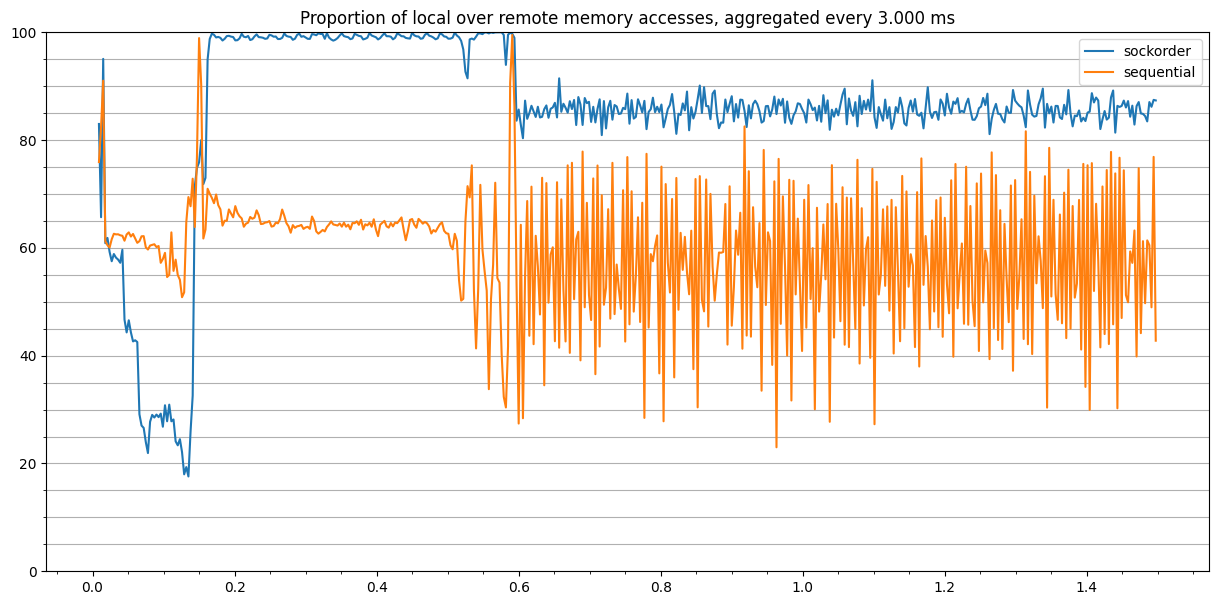

In [28]:
plot_access_locality_over_time([sock_df, seq_df], ["sockorder", "sequential"], min_t=0.0, max_t=1.5)

### Event counts per CPU

In [43]:
def plot_event_count_per_cpu(df: pd.DataFrame, event: str) :
    filtered_df = df.loc[df['event'] == event]
    # cpu_sorted = [i for i in range(64) if i % 2 == 0] + [i for i in range(64) if i % 2 == 1]
    cpu_remote_l3_loads = [filtered_df.loc[filtered_df['cpuid'] == cpuid]['period'].sum() for cpuid in range(64)] 

    bars = plt.bar(range(len(cpu_remote_l3_loads)), cpu_remote_l3_loads, width=0.8)
    for item in bars[::2]:
        item.set_color('tab:orange')
    plt.ylim(0, max(cpu_remote_l3_loads) * 1.1)
    plt.xticks([i for i in range(65) if i % 2 == 0])
    plt.minorticks_on()
    plt.gcf().set_size_inches(15, 8)
    plt.tick_params(axis='x', which='minor', bottom=False)
    plt.title(f"Number {event} events per core\nTotal " + '{:.4e}'.format(sum(cpu_remote_l3_loads)) + "")
    plt.show()

In [31]:
len(sock_df['cpuid'].unique())

64

In [38]:
sock_df.groupby('cpuid')['period'].sum()

cpuid
0     102107950
1     110863800
2     100417600
3     110609300
4     101917800
        ...    
59    120005350
60    111703550
61    121333200
62    119748000
63    118905300
Name: period, Length: 64, dtype: int64

In [46]:
sock_df['event'].value_counts()

event
cpu/mem-stores,period=2000/P              2479812
cpu/mem-loads,period=2000/P               1047577
mem_load_l3_miss_retired.remote_hitm:P     488043
mem_load_l3_miss_retired.remote_fwd:P      461683
mem_load_l3_miss_retired.remote_dram:P     192214
Name: count, dtype: int64

In [56]:
def plot_event_count_per_cpu(dfs: List[pd.DataFrame], names: List[str], event: str) :
    dfs = [df.loc[df['event'] == event] for df in dfs]
    dfs = [df.groupby('cpuid')['period'].sum().reset_index() for df in dfs]
    
    for df, name in zip(dfs, names):
        df['source'] = name
        
    combined_df = pd.concat(dfs)
        
    plt.figure(figsize=(10, 6))
    sns.barplot(x='cpuid', y='period', hue='source', data=combined_df)

    # Add labels and title
    plt.xlabel('CPU')
    plt.ylabel('Sum of Events')
    plt.title('Sum of Events per CPU')
    plt.show()
    

[    cpuid   period     source
0       0    17550  sockorder
1       1    18600  sockorder
2       2     4150  sockorder
3       3    18350  sockorder
4       4    11050  sockorder
..    ...      ...        ...
59     59    17100  sockorder
60     60      700  sockorder
61     61    14350  sockorder
62     62  9131450  sockorder
63     63    18450  sockorder

[64 rows x 3 columns],     cpuid    period      source
0       0   2200950  sequential
1       1   4399200  sequential
2       2   6271350  sequential
3       3   8346400  sequential
4       4  10499350  sequential
..    ...       ...         ...
59     59   4041150  sequential
60     60   6649700  sequential
61     61   8240900  sequential
62     62  10703500  sequential
63     63     95650  sequential

[64 rows x 3 columns]]


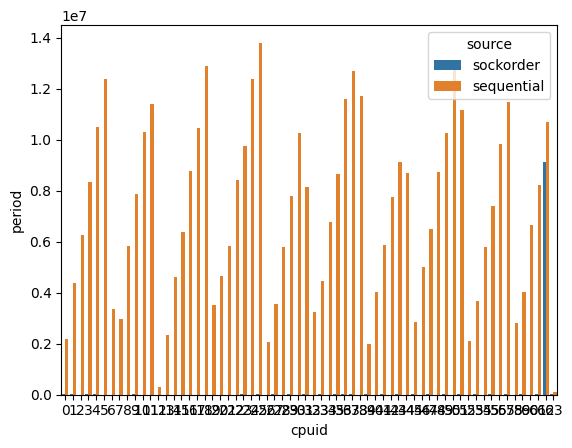

In [57]:
plot_event_count_per_cpu([sock_df, seq_df], ["sockorder", "sequential"], "mem_load_l3_miss_retired.remote_dram:P")

In [35]:
configs_colors = ["tab:blue", "tab:orange"]

# TODO Sort by node but still have the correct cpuid
def plot_event_count_per_cpu(dfs: List[pd.DataFrame], event: str) :
    dfs = [df.loc[df['event'] == event] for df in dfs]
    # cpu_sorted = [i for i in range(64) if i % 2 == 0] + [i for i in range(64) if i % 2 == 1]
    # cpu_remote_l3_loads = [filtered_df.loc[filtered_df['cpuid'] == cpuid]['period'].sum() for cpuid in range(64)]
    
    
    # total_width : float, optional, default: 0.8
    #     The width of a bar group. 0.8 means that 80% of the x-axis is covered
    #     by bars and 20% will be spaces between the bars.

    # single_width: float, optional, default: 1
    #     The relative width of a single bar within a group. 1 means the bars
    #     will touch eachother within a group, values less than 1 will make
    #     these bars thinner.
    
    total_width = 0.8
    single_width = 1
    
    # Number of bars per group
    n_bars = len(dfs)
    
    # The width of a single bar
    bar_width = total_width / n_bars
    
    for i, df in enumerate(dfs):
        n_cpus = len(df['cpuid'].unique())
        n_events_per_cpu = [df.loc[df['cpuid'] == cpuid]['period'].sum() for cpuid in range(n_cpus)]

        # List containing handles for the drawn bars, used for the legend
        bars = []
        
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
        
        # Draw a bar for every value of that type
        for x, y in enumerate(n_events_per_cpu):
            bar = plt.bar(x + x_offset, y, width=bar_width * single_width, color=configs_colors[i % len(configs_colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])
        
    # if legend:
    #     ax.legend(bars, data.keys())

#         bars = plt.bar(range(len(cpu_remote_l3_loads)), cpu_remote_l3_loads, width=0.8)
#         for item in bars[::2]:
#             item.set_color('tab:orange')
#         plt.ylim(0, max(cpu_remote_l3_loads) * 1.1)
#         plt.xticks([i for i in range(65) if i % 2 == 0])
#         plt.minorticks_on()
#         plt.gcf().set_size_inches(15, 8)
#         plt.tick_params(axis='x', which='minor', bottom=False)
#         plt.title(f"Number {event} events per core\nTotal " + '{:.4e}'.format(sum(cpu_remote_l3_loads)) + "")
#         plt.show()

# ax = plt.subplot(111)
# w = 0.3
# ax.bar(x-w, y, width=w, color='b', align='center')
# ax.bar(x, z, width=w, color='g', align='center')
# ax.bar(x+w, k, width=w, color='r', align='center')
# ax.xaxis_date()
# ax.autoscale(tight=True)

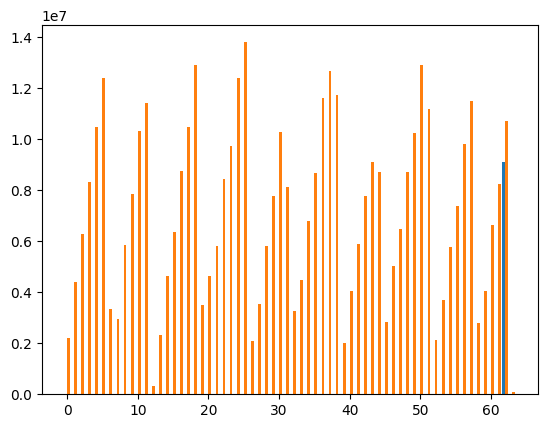

In [36]:
plot_event_count_per_cpu([sock_df, seq_df], "mem_load_l3_miss_retired.remote_dram:P")

In [33]:
print(events_df['event'].unique())
for event in events_df['event'].unique() :
    plot_event_count_per_cpu(events_df, event)

NameError: name 'events_df' is not defined

## Address space

### Vizualization

In [45]:
def relative_to_bounds(bounds: Tuple[int, int], relative_range = 1000):
    min_range = events_df['phys'].min()
    max_range = events_df['phys'].max()
    range = max_range - min_range
    return int((bounds[0] / relative_range) * range), int((bounds[1] / relative_range) * range)

def bounds_to_relative(bounds: Tuple[int, int], relative_range = 1000):
    min_range = events_df['phys'].min()
    max_range = events_df['phys'].max()
    range = max_range - min_range
    return (bounds[0] * relative_range) / range, (bounds[1] * relative_range) / range

In [ ]:
phys_clusters_alt = grouping.get_groups(events_df['phys'].to_numpy(), 1e9, 1)
for i, cluster in enumerate(phys_clusters_alt):
    print_cluster_info(i, cluster)

In [ ]:
phys_clusters = get_cluster_bounds(events_df['phys'].to_numpy(), 1e9, 1)

In [ ]:
for i, cluster in enumerate(phys_clusters):
    print_cluster_info(i, cluster)

Cluster 4 -- bounds : (7354191872, 8279554920), size : 9.254e+08, total events : 267179
Cluster 5 -- bounds : (8279555848, 8977907704), size : 6.984e+08, total events : 839893

Cluster 4 -- bounds : (7354191872, 8279555848), size : 9.254e+08, total events : 267180
Cluster 5 -- bounds : (8615100568, 9609760752), size : 9.947e+08, total events : 1366011


We are actually doing 2 level clustering in order to see a bit better the clusters :
1) Compute large clusters so as to have like 4 or 5
2) Within each of those clusters, compute the desired size clusters

In [47]:
events_physical_addresses = events_df['phys'].to_numpy()
outer_groups = get_groups(events_physical_addresses, 3e10, 1000)
print_groups(outer_groups)

Group 0 -- bounds : (4295331896, 33330797632), width : 2.904e+10, size : 2159472
Group 1 -- bounds : (102552395776, 107191724672), width : 4.639e+09, size : 1916562
Group 2 -- bounds : (207134887224, 207232165968), width : 9.728e+07, size : 2665


In [ ]:
inner_df = extract_group(events_df, outer_groups[0], variable="phys").sort_values("phys").reset_index(drop=True)
# inner_df.reset_index(drop=True)
inner_df

In [1]:
fig, axs = plt.subplots(1, len(outer_groups), figsize=(20, 20))

for i, og in enumerate(outer_groups):
    inner_df = extract_group(events_df, og, variable="phys").sort_values("phys").reset_index(drop=True)
    # sorted_local_physaddr = np.sort(extract_group(events_physical_addresses, og))
    sorted_local_physaddr = inner_df["phys"].to_numpy()
    inner_groups = get_groups(sorted_local_physaddr, 1e7, 1000)
    # print_groups(inner_groups)
    
    axs[i].plot(range(len(sorted_local_physaddr)), sorted_local_physaddr)
    for cluster in inner_groups :
        axs[i].axhline(y=cluster[0], color='g', linestyle='--', linewidth=0.2)
        axs[i].axhline(y=cluster[1], color='g', linestyle='--', linewidth=0.2)
        
    relative_bounds = bounds_to_relative(og, relative_range=100)
    axs[i].set_title(f"{'{:.2f}'.format(relative_bounds[0])} - {'{:.2f}'.format(relative_bounds[1])} % of entire address space")
    
    l3_miss_dram_df = inner_df.loc[inner_df['event'] == "mem_load_l3_miss_retired.remote_dram:P"]
    l3_miss_fwd_df = inner_df.loc[inner_df['event'] == "mem_load_l3_miss_retired.remote_fwd:P"]
    l3_miss_hitm_df = inner_df.loc[inner_df['event'] == "mem_load_l3_miss_retired.remote_hitm:P"]
    
    if len(l3_miss_dram_df) > 0:
        axs[i].scatter(l3_miss_dram_df.index, l3_miss_dram_df['phys'], label="l3 miss remote dram", color='r', s=4, alpha=0.5, zorder=3)
    if len(l3_miss_fwd_df) > 0:
        axs[i].scatter(l3_miss_fwd_df.index, l3_miss_fwd_df['phys'], label="l3 miss remote fwd", color='tab:orange', s=4, alpha=0.5, zorder=4)
    if len(l3_miss_hitm_df) > 0:
        axs[i].scatter(l3_miss_hitm_df.index, l3_miss_hitm_df['phys'], label="l3 miss remote hitm", color='tab:pink', s=4, alpha=0.5, zorder=5)
    
    # for event in inner_df['event'].unique() :
    #     if "l3_miss_retired.remote_dram" not in event:
    #         continue
    #     # plot_event_count_per_cpu(events_df_sorted_phys, event)
    #     filtered_df = events_df_sorted_phys.loc[events_df_sorted_phys['event'] == event]
    #     plt.scatter(filtered_df.index, filtered_df['phys'], label=event, c='r', s=2, alpha=0.8, zorder=10)

    # # plt.scatter(l3_remote_df.index, l3_remote_df['phys'], s=2, color='r', alpha=0.1)

    # plt.axhline(y=NODE_1_PHYS_ADDR_START, color='r', linestyle='--', linewidth=0.8)
    # plt.gcf().set_size_inches(10, 15)
    # plt.title("Physical addresses ordered")
    # plt.legend(title='Cache Result', loc="best")
plt.show()
    
    

NameError: name 'plt' is not defined

In [ ]:
# print(len(events_df))
phys_groups = get_groups(events_df['phys'].to_numpy(), 1e9, 4000)

events_df_sorted_phys = events_df.sort_values('phys', ignore_index=True)

plt.plot(events_df_sorted_phys.index, events_df_sorted_phys['phys'])
for cluster in phys_groups :
    plt.axhline(y=cluster[0], color='g', linestyle='--', linewidth=0.2)
    plt.axhline(y=cluster[1], color='g', linestyle='--', linewidth=0.2)
    
for event in events_df_sorted_phys['event'].unique() :
    if "l3_miss_retired.remote_dram" not in event:
        continue
    # plot_event_count_per_cpu(events_df_sorted_phys, event)
    filtered_df = events_df_sorted_phys.loc[events_df_sorted_phys['event'] == event]
    plt.scatter(filtered_df.index, filtered_df['phys'], label=event, c='r', s=2, alpha=0.8, zorder=10)

# plt.scatter(l3_remote_df.index, l3_remote_df['phys'], s=2, color='r', alpha=0.1)

plt.axhline(y=NODE_1_PHYS_ADDR_START, color='r', linestyle='--', linewidth=0.8)
plt.gcf().set_size_inches(20, 20)
plt.title("Physical addresses ordered")
plt.legend(title='Cache Result', loc="best")
plt.show()

# events_df_sorted_phys

### Clustering

In [ ]:
def get_stats_for_event_in_cluster(df: pd.DataFrame, cluster: tuple, event: str):
    bounded_subset = filter_in_bounds(df, 'phys', cluster)
    event_subset = bounded_subset.loc[bounded_subset['event'] == event]
    if len(event_subset) == 0 :
        return None
    cpuids = event_subset['cpuid'].unique()
    count_per_cpu: List[Tuple[int, int]] = []
    for cid in cpuids:
        number = (event_subset['cpuid'] == cid).sum()
        count_per_cpu.append((number, cid))
    # display(event_subset)
    return (cluster[0], cluster[1], len(event_subset), sorted(count_per_cpu, reverse=True))

def print_cluster_info(name, cluster: Tuple[int, int, int]):
    print(f"Cluster {name} -- bounds : {cluster[0], cluster[1]}, size : {'{:.3e}'.format(cluster[1] - cluster[0])}, total events : {cluster[2]}")

def get_clusters_that_contain_event(df: pd.DataFrame, clusters: list, event: str):
    # clusters could be converted to named tuple
    res = []
    for cluster in clusters:
        bounded_subset = filter_in_bounds(df, 'phys', cluster)
        event_subset = bounded_subset.loc[bounded_subset['event'] == event]
        if len(event_subset) > 0 :
            cpuids = event_subset['cpuid'].unique()
            count_per_cpu: List[Tuple[int, int]] = []
            for cid in cpuids:
                number = (event_subset['cpuid'] == cid).sum()
                count_per_cpu.append((number, cid))
            # display(event_subset)
            res.append((cluster[0], cluster[1], len(event_subset), sorted(count_per_cpu, reverse=True)))
    return sorted(res, reverse=True, key=lambda x: x[2])


def merge_clusters(clusters: list):
    starts = [c[0] for c in clusters]
    ends = [c[1] for c in clusters]
    return (min(starts), max(ends))

In [ ]:
clusters_for_event = get_clusters_that_contain_event(events_df, phys_clusters, "mem_load_l3_miss_retired.remote_dram:P")
for i, cluster in enumerate(clusters_for_event) :
    print(f"Cluster {i} -- bounds : {cluster[0], cluster[1]}, size : {'{:.3e}'.format(cluster[1] - cluster[0])}, total events : {cluster[2]}, list of (n events on cpu, cpu) : {cluster[3]}")
    if i > 20:
        break

In [ ]:
def plotmem(df: pd.DataFrame, column: str = 'phys', cpuid = [], exclude_cpuid = [], min_t = None, max_t = None, w = 60, h = 30, dot_size = 10) :
    cpu_df = df.loc[df['cpuid'].isin(cpuid)] if cpuid else df
    cpu_df = df.loc[~df['cpuid'].isin(exclude_cpuid)] if exclude_cpuid else cpu_df
    bounded_df = cpu_df
    
    if max_t is not None :
        if min_t is None :
            min_t = 0.0
        bounded_df = filter_in_bounds(bounded_df, 'time', (min_t, max_t))
    
    loads_df = bounded_df.loc[bounded_df['event'] == "cpu/mem-loads/P"]
    stores_df = bounded_df.loc[bounded_df['event'] == "cpu/mem-stores/P"]
    l3_miss_dram_df = bounded_df.loc[bounded_df['event'] == "mem_load_l3_miss_retired.remote_dram:P"]
    l3_miss_fwd_df = bounded_df.loc[bounded_df['event'] == "mem_load_l3_miss_retired.remote_fwd:P"]
    l3_miss_hitm_df = bounded_df.loc[bounded_df['event'] == "mem_load_l3_miss_retired.remote_hitm:P"]
    
    plt.gcf().set_size_inches(w, h)
    plt.scatter(loads_df['time'], loads_df[column], label="Memory loads", color='tab:green', s=dot_size, alpha=0.3, zorder=1)
    plt.scatter(stores_df['time'], stores_df[column], label="Memory stores", color='tab:blue', s=dot_size, alpha=0.3, zorder=2)
    if len(l3_miss_dram_df) > 0:
        plt.scatter(l3_miss_dram_df['time'], l3_miss_dram_df[column], label="l3 miss remote dram", color='r', s=dot_size, alpha=0.5, zorder=3)
    if len(l3_miss_fwd_df) > 0:
        plt.scatter(l3_miss_fwd_df['time'], l3_miss_fwd_df[column], label="l3 miss remote fwd", color='tab:orange', s=dot_size, alpha=0.5, zorder=4)
    if len(l3_miss_hitm_df) > 0:
        plt.scatter(l3_miss_hitm_df['time'], l3_miss_hitm_df[column], label="l3 miss remote hitm", color='tab:pink', s=dot_size, alpha=0.5, zorder=5)
    
    # TODO Plot the other types of L3 miss with different color like orange and purple
    # plt.scatter(l3_miss_remote_df['time'], l3_miss_remote_df['phys'], label="l3 miss remote dram", color='r', s=3, alpha=0.5, zorder=10)
    
    cpuids = bounded_df['cpuid'].unique()
    for cid in cpuids :
        curr_df = bounded_df.loc[bounded_df['cpuid'] == cid]
        plt.plot(curr_df['time'], curr_df[column], label=f"CPU {cid}", linestyle='--', linewidth=0.4, alpha=0.5)
        
    plt.minorticks_on()
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    plt.xlabel('Time')
    plt.ylabel('Phys')
    plt.title('Scatter Plot of Time vs Phys with Cache Results Colored')
    plt.legend(title='Cache Result', loc='upper right')
    plt.show()

In [ ]:
# 'cpu/mem-loads/P' 'cpu/mem-stores/P'
#  'mem_load_l3_miss_retired.local_dram:P'
#  'mem_load_l3_miss_retired.remote_dram:P'
#  'mem_load_l3_miss_retired.remote_hitm:P'
#  'mem_load_l3_miss_retired.remote_fwd:P']

def plot_phys(df: pd.DataFrame, phys_bounds: tuple, cpuid = [], exclude_cpuid = [], min_t = None, max_t = None, w = 60, h = 30, dot_size = 3) :
    cpu_df = df.loc[df['cpuid'].isin(cpuid)] if cpuid else df
    cpu_df = df.loc[~df['cpuid'].isin(exclude_cpuid)] if exclude_cpuid else cpu_df
    bounded_df = filter_in_bounds(cpu_df, 'phys', phys_bounds)
    
    if max_t is not None :
        if min_t is None :
            min_t = 0.0
        bounded_df = filter_in_bounds(bounded_df, 'time', (min_t, max_t))
    
    loads_df = bounded_df.loc[bounded_df['event'] == "cpu/mem-loads/P"]
    stores_df = bounded_df.loc[bounded_df['event'] == "cpu/mem-stores/P"]
    l3_miss_dram_df = bounded_df.loc[bounded_df['event'] == "mem_load_l3_miss_retired.remote_dram:P"]
    l3_miss_fwd_df = bounded_df.loc[bounded_df['event'] == "mem_load_l3_miss_retired.remote_fwd:P"]
    l3_miss_hitm_df = bounded_df.loc[bounded_df['event'] == "mem_load_l3_miss_retired.remote_hitm:P"]
    
    plt.gcf().set_size_inches(w, h)
    plt.scatter(loads_df['time'], loads_df['phys'], label="Memory loads", color='tab:green', s=dot_size, alpha=0.3, zorder=1)
    plt.scatter(stores_df['time'], stores_df['phys'], label="Memory stores", color='tab:blue', s=dot_size, alpha=0.3, zorder=2)
    if len(l3_miss_dram_df) > 0:
        plt.scatter(l3_miss_dram_df['time'], l3_miss_dram_df['phys'], label="l3 miss remote dram", color='r', s=dot_size, alpha=0.5, zorder=3)
    if len(l3_miss_fwd_df) > 0:
        plt.scatter(l3_miss_fwd_df['time'], l3_miss_fwd_df['phys'], label="l3 miss remote fwd", color='tab:orange', s=dot_size, alpha=0.5, zorder=4)
    if len(l3_miss_hitm_df) > 0:
        plt.scatter(l3_miss_hitm_df['time'], l3_miss_hitm_df['phys'], label="l3 miss remote hitm", color='tab:pink', s=dot_size, alpha=0.5, zorder=5)
    
    # TODO Plot the other types of L3 miss with different color like orange and purple
    # plt.scatter(l3_miss_remote_df['time'], l3_miss_remote_df['phys'], label="l3 miss remote dram", color='r', s=3, alpha=0.5, zorder=10)
    
    cpuids = bounded_df['cpuid'].unique()
    for cid in cpuids :
        curr_df = bounded_df.loc[bounded_df['cpuid'] == cid]
        plt.plot(curr_df['time'], curr_df['phys'], label=f"CPU {cid}", linestyle='--', linewidth=0.4, alpha=0.5)
        
        # break

    # fig = plt.gcf()
    # if width is None :
    #     width = 28
    # if height is None :
    #     height = 12
    # plt.gcf().set_size_inches(120, 60)
    # plt.gcf().set_size_inches(60, 30)
    plt.minorticks_on()
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    plt.xlabel('Time')
    plt.ylabel('Phys')
    plt.title('Scatter Plot of Time vs Phys with Cache Results Colored')
    plt.legend(title='Cache Result', loc='upper right')
    plt.show()

In [ ]:
def relative_to_bounds(bounds: Tuple[int, int], relative_range = 1000):
    min_range = events_df['phys'].min()
    max_range = events_df['phys'].max()
    range = max_range - min_range
    return int((bounds[0] / 1000) * range), int((bounds[1] / 1000) * range)

def bounds_to_relative(bounds: Tuple[int, int], relative_range = 1000):
    min_range = events_df['phys'].min()
    max_range = events_df['phys'].max()
    range = max_range - min_range
    return (bounds[0] * 1000) / range, (bounds[1] * 1000) / range

In [ ]:
print(bounds_to_relative(clusters_for_event[8]))
new_bounds = relative_to_bounds((48.3422, 50.4363))
new_bounds

In [ ]:
plot_phys(events_df, clusters_for_event[0], min_t=0.7, max_t=0.8, w = 30, h = 15, dot_size=30)

In [ ]:
filtered_df = filter_in_bounds(events_df, "phys", clusters_for_event[0])
filtered_df = filtered_df.loc[(filtered_df['cpuid'] == 4) & (filtered_df['event'] == "mem_load_l3_miss_retired.remote_dram:P")]

filtered_clusters = get_cluster_bounds(filtered_df['phys'].to_numpy(), 1e6, 10)
for i, cluster in enumerate(filtered_clusters) :
    print_cluster_info(i, cluster)

In [ ]:
plotmem(events_df, filtered_clusters[1], 'virt', max_t=0.8, w = 30, h = 15, dot_size=40)

In [ ]:
plot_phys(events_df, filtered_clusters[1], max_t=0.8, w = 30, h = 15, dot_size=40)

In [ ]:
plot_phys(events_df, (0, NODE_1_PHYS_ADDR_START), max_t=0.8, w = 30, h = 15, dot_size=40)

In [ ]:
plot_phys(events_df, (0, 0.18 * 1e11), max_t=0.8, w = 30, h = 15, dot_size=40)

In [ ]:
plot_phys(events_df, (NODE_1_PHYS_ADDR_START, 1.08 * 1e11), cpuid=[4], min_t=1.0, max_t=1.06, w = 30, h = 15, dot_size=40)

In [ ]:
plotmem(events_df, (NODE_1_PHYS_ADDR_START, 1.08 * 1e11), column="virt", cpuid=[4], min_t=1.0, max_t=1.06, w = 30, h = 15, dot_size=40)

In [ ]:
plotmem(filter_in_bounds(events_df, "virt", (1.3 * 1e14, 1.5 * 1e14)), column="virt", cpuid=[4], min_t=1.0, max_t=1.03, w = 30, h = 15, dot_size=40)

In [ ]:
cpu4virt = events_df.loc[events_df['cpuid'] == 4]["virt"].to_numpy()
vgroups4 = get_groups(cpu4virt, 1e9, 100)
print_groups(vgroups4)

In [ ]:
grouping.plot_group(cpu4virt, vgroups4[1])

In [ ]:
vclusters4 = get_cluster_bounds(events_df.loc[events_df['cpuid'] == 4]["virt"], 1e9, 10)
vclusters4

In [ ]:
filtered_df = filter_in_bounds(events_df.loc[events_df['cpuid'] == 4], "virt", vclusters4[2])
vaddresses = np.array(filtered_df["virt"])
vaddresses.sort()
plt.plot(range(len(vaddresses)), vaddresses)

In [ ]:
plotmem(events_df, (0, NODE_1_PHYS_ADDR_START), column="phys", cpuid=[4], min_t=1.0, max_t=1.03, w = 30, h = 15, dot_size=40)

In [ ]:
plotmem(filter_in_bounds(events_df, "phys", (NODE_1_PHYS_ADDR_START, 1.15 * 1e11)), column="phys", cpuid=[4], min_t=1.0, max_t=1.03, w = 30, h = 15, dot_size=40)

In [ ]:
plot_phys(events_df, (NODE_1_PHYS_ADDR_START, 1.07 * 1e11), cpuid=[26], min_t=1.0, max_t=1.06, w = 30, h = 15, dot_size=40)

In [ ]:
plot_phys(events_df, (NODE_1_PHYS_ADDR_START, 1.07 * 1e11), cpuid=[28], min_t=1.0, max_t=1.06, w = 30, h = 15, dot_size=40)

In [ ]:
plot_phys(events_df, (NODE_1_PHYS_ADDR_START, 1.12 * 1e11), cpuid=[30], min_t=1.0, max_t=1.06, w = 30, h = 15, dot_size=40)

In [ ]:
plot_phys(events_df, (1.0048 * 1e10, 1.0054 * 1e10), min_t=0.7, max_t=0.9)

In [ ]:
plot_phys(events_df, (1.0048 * 1e10, 1.0054 * 1e10), min_t=0.7, max_t=0.9)

In [ ]:
plot_phys(events_df, (1.0072 * 1e10, 1.0074 * 1e10), min_t=0.7, max_t=0.9, cpuid=[30], w = 20, h = 10, dot_size=30)

In [ ]:
plot_phys(events_df, (1.0072 * 1e10, 1.0074 * 1e10), cpuid=[30], w = 20, h = 10, dot_size=30)

In [ ]:
get_stats_for_event_in_cluster(events_df, (1.0072 * 1e10, 1.0074 * 1e10), "mem_load_l3_miss_retired.remote_fwd:P")

In [ ]:
plot_phys(events_df, merge_clusters(clusters_for_event[7:9]), min_t=0.8, max_t=0.9, cpuid=[47])

In [ ]:
plot_phys(events_df, (5.54 * 1e9, 5.56 * 1e9), min_t=0.8, max_t=0.9, cpuid=[47])

In [ ]:
print(bounds_to_relative((5.54 * 1e9, 5.56 * 1e9)))
print(relative_to_bounds((26.7333, 26.8298)))

In [ ]:
plot_phys(events_df, (5539999664, 5559997568), max_t=1.0, cpuid=[47])

In [ ]:
-0.5 * 1e6 + 1.005e10

In [ ]:
2 * 1e6 + 1.005e10

In [ ]:
curr_bounds = (10049500000, 10052000000)

In [ ]:
plot_phys(df=events_df, phys_bounds=(10049552384, 10053746412), min_t=1.63, max_t=1.67)

In [ ]:
# plot_phys(events_df, clusters_for_event[14], exclude_cpuid=[62], min_t=1.40, max_t=1.45)

In [ ]:
plot_phys(events_df, clusters_for_event[0])

In [ ]:
def plot_virt(df: pd.DataFrame, cpuid = [], exclude_cpuid = [], min_t = None, max_t = None) :
    cpu_df = df.loc[df['cpuid'].isin(cpuid)] if cpuid else df
    bounded_df = df.loc[~df['cpuid'].isin(exclude_cpuid)] if exclude_cpuid else cpu_df
    
    if max_t is not None :
        if min_t is None :
            min_t = 0.0
        bounded_df = filter_in_bounds(bounded_df, 'time', (min_t, max_t))
        
    loads_df = bounded_df.loc[bounded_df['event'] == "cpu/mem-loads/P"]
    stores_df = bounded_df.loc[bounded_df['event'] == "cpu/mem-stores/P"]
    l3_miss_remote_df = bounded_df.loc[bounded_df['event'] == "mem_load_l3_miss_retired.remote_dram:P"]
    
    metric="virt"
    
    plt.scatter(loads_df['time'], loads_df[metric], label="Memory loads", color='tab:green', s=3, alpha=0.5, zorder=10)
    plt.scatter(stores_df['time'], stores_df[metric], label="Memory stores", color='tab:blue', s=3, alpha=0.5, zorder=15)
    plt.scatter(l3_miss_remote_df['time'], l3_miss_remote_df[metric], label="l3 miss remote dram", color='r', s=3, alpha=0.5, zorder=10)
    
    cpuids = bounded_df['cpuid'].unique()
    for cid in cpuids :
        curr_df = bounded_df.loc[bounded_df['cpuid'] == cid]
        plt.plot(curr_df['time'], curr_df[metric], label=f"CPU {cid}", linestyle='--', linewidth=0.4, alpha=0.5)
        
        # break

    # fig = plt.gcf()
    # if width is None :
    #     width = 28
    # if height is None :
    #     height = 12
    # plt.gcf().set_size_inches(120, 60)
    plt.gcf().set_size_inches(60, 30)
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    plt.xlabel('Time')
    plt.ylabel('Virt')
    plt.title('Scatter Plot of Time vs Virt with Cache Results Colored')
    plt.legend(title='Cache Result', loc='upper right')
    plt.show()

In [ ]:
filtered_df = filter_in_bounds(events_df, 'phys', curr_bounds)
filtered_df

In [ ]:
filtered_df['event'].value_counts()

In [ ]:
plot_virt(filtered_df)

In [ ]:
sorted(filtered_df['virt'].to_numpy())[-10:]

In [ ]:
virt_clusters = get_cluster_bounds(filtered_df['virt'].to_numpy(), 1e6, 0)

# plot_virt(df=events_df, phys_bounds=curr_bounds, max_t=0.8)
virt_clusters

In [ ]:
plot_virt(filter_in_bounds(filtered_df, 'virt', virt_clusters[0]), max_t=0.8)

In [ ]:
plot_virt(filter_in_bounds(filtered_df, 'virt', virt_clusters[1]), max_t=0.8)

## Fixed address investigation

In [ ]:
fwd_subset = events_df.loc[events_df['event'] == "mem_load_l3_miss_retired.remote_fwd:P"]
hitm_subset = events_df.loc[events_df['event'] == "mem_load_l3_miss_retired.remote_hitm:P"]
dram_subset = events_df.loc[events_df['event'] == "mem_load_l3_miss_retired.remote_dram:P"]

print(f"fwd percentage of same node : {local_access_proportion(fwd_subset)}")
print(f"hitm percentage of same node : {local_access_proportion(hitm_subset)}")
print(f"dram percentage of same node : {local_access_proportion(dram_subset)}")

same_node_dram = get_same_node(dram_subset)
same_node_fwd = get_same_node(fwd_subset)
same_node_fwd.loc[same_node_fwd['time'] > 0.1]

In [ ]:
same_node_dram

In [ ]:
page_size = 1024
pages_width = 200
single_phys = 9391753584
single_bounds = (int(single_phys - pages_width * page_size), int(single_phys + pages_width * page_size))

In [ ]:
plot_phys(events_df, single_bounds, w = 20, h = 10, dot_size=30, max_t=0.18)